In [ ]:
!pip install opendatasets
!pip install gensim

In [1]:

import opendatasets as od
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
def load_dataset():
    od.download("https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification")
    csv_path = "ecommerce-text-classification/ecommerceDataset.csv"
    df = pd.read_csv(csv_path)
    df = df.iloc[:, :2]
    df.columns = ["category", "description"]
    df.dropna(inplace=True)
    df["description"] = df["description"].astype(str)
    df["category"] = df["category"].astype(str)
    return df

In [5]:
df = load_dataset()

Skipping, found downloaded files in ".\ecommerce-text-classification" (use force=True to force download)


---

## phase 0: data profiling

In [ ]:
# Shape and structure
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

Shape: (50423, 2)

Columns: ['category', 'description']


In [ ]:
df.head()

,category,description
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...


In [ ]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50423 entries, 0 to 50423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     50423 non-null  object
 1   description  50423 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
# Missing values
df.isnull().sum()

category       0
description    0
dtype: int64

In [ ]:
dup_mask = df.duplicated(subset=["description"], keep=False)

print("Total duplicate rows:", dup_mask.sum())


Total duplicate rows: 36601


In [ ]:
dup_counts = df["description"].value_counts()
dup_counts[dup_counts > 1].head()


Think & Grow Rich About the Author NAPOLEON HILL, born in Pound, Southwest Virginia in 1883, was a very successful American author in the area of the new thought movement—one of the earliest producers of the modern genre of personal-success literature. He is widely considered to be one of the great writers on success. The turning point in Hill’s life occurred in the year 1908 when he interviewed the industrialist Andrew Carnegie—one of the most powerful men in the world at that time, as part of an assignment—an interview which ultimately led to the publication of Think and Grow Rich, one of his best-selling books of all time. the book examines the power of personal beliefs and the role they play in personal success. Hill, who had even served as the advisor to President Franklin D. Roosevelt from 1933-36, passed away at the age of 87.                                                                                                                                                           

In [7]:
df["description"].nunique()

27801

In [ ]:
# Count number of descriptions per category
category_counts = df.groupby("category")["description"].count().reset_index()

category_counts = category_counts.rename(columns={"description": "num_descriptions"})
category_counts

,category,num_descriptions
0,Books,11820
1,Clothing & Accessories,8670
2,Electronics,10621
3,Household,19312


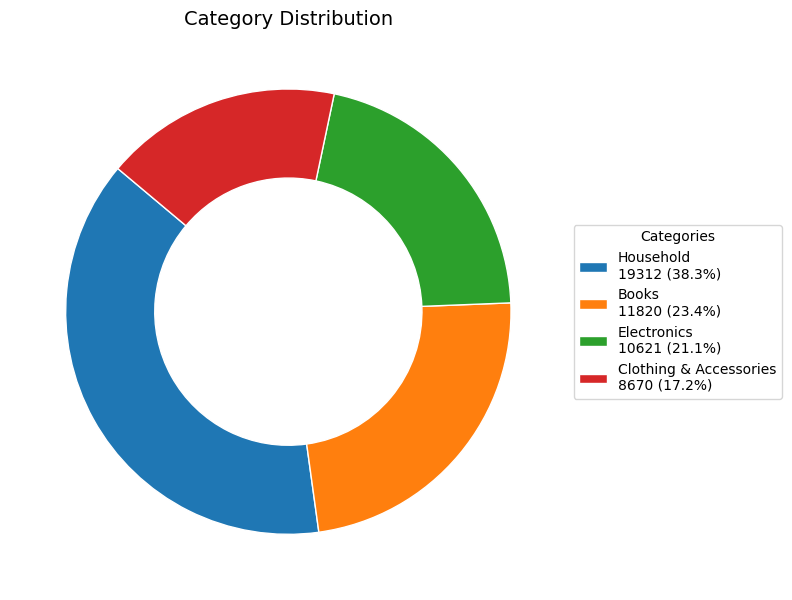

In [ ]:
def plot_category_distribution(df, cat_col="category"):
    """
    Plots a donut (pizza-like) chart for category distribution with better percentages.
    """
    category_counts = df[cat_col].value_counts()
    labels = [f"{cat}\n{count} ({count/len(df)*100:.1f}%)"
              for cat, count in zip(category_counts.index, category_counts.values)]

    fig, ax = plt.subplots(figsize=(8,8))
    wedges, texts = ax.pie(
        category_counts,
        startangle=140,
        wedgeprops=dict(width=0.4, edgecolor="w")
    )

    ax.legend(wedges, labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

    ax.set_title("Category Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_category_distribution(df, cat_col="category")

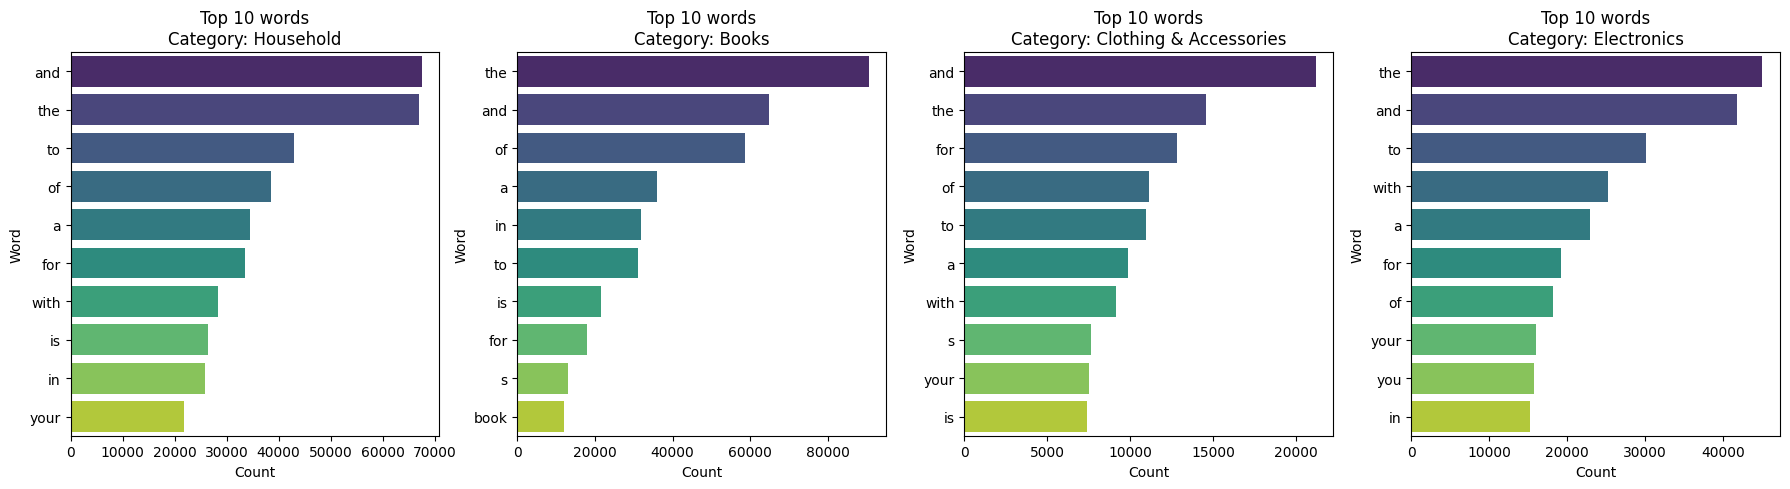

In [ ]:
def plot_top_words_per_category(df, text_col="description", cat_col="category", top_n=10, max_classes=4):
    """
    Plots top-N most frequent words per category (up to max_classes categories).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing text and categories.
    text_col : str
        Column name of text descriptions.
    cat_col : str
        Column name of categories.
    top_n : int
        Number of top words to display.
    max_classes : int
        Number of categories to plot (max).
    """
    categories = df[cat_col].unique()[:max_classes]
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 5), sharey=False)

    if len(categories) == 1:
        axes = [axes]  # make iterable if only one category

    for ax, cat in zip(axes, categories):
        # Get all text for this category
        texts = df.loc[df[cat_col] == cat, text_col].astype(str).str.lower().tolist()
        all_text = " ".join(texts)

        # Clean: keep only letters and spaces
        all_text = re.sub(r"[^a-z\s]", " ", all_text)
        tokens = all_text.split()

        # Word frequency
        freq = Counter(tokens).most_common(top_n)
        words, counts = zip(*freq) if freq else ([], [])

        sns.barplot(
            x=list(counts),
            y=list(words),
            hue=list(words),
            dodge=False,
            legend=False,
            palette="viridis",
            ax=ax
        )

        ax.set_title(f"Top {top_n} words\nCategory: {cat}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()


plot_top_words_per_category(df, text_col="description", cat_col="category", top_n=10, max_classes=4)


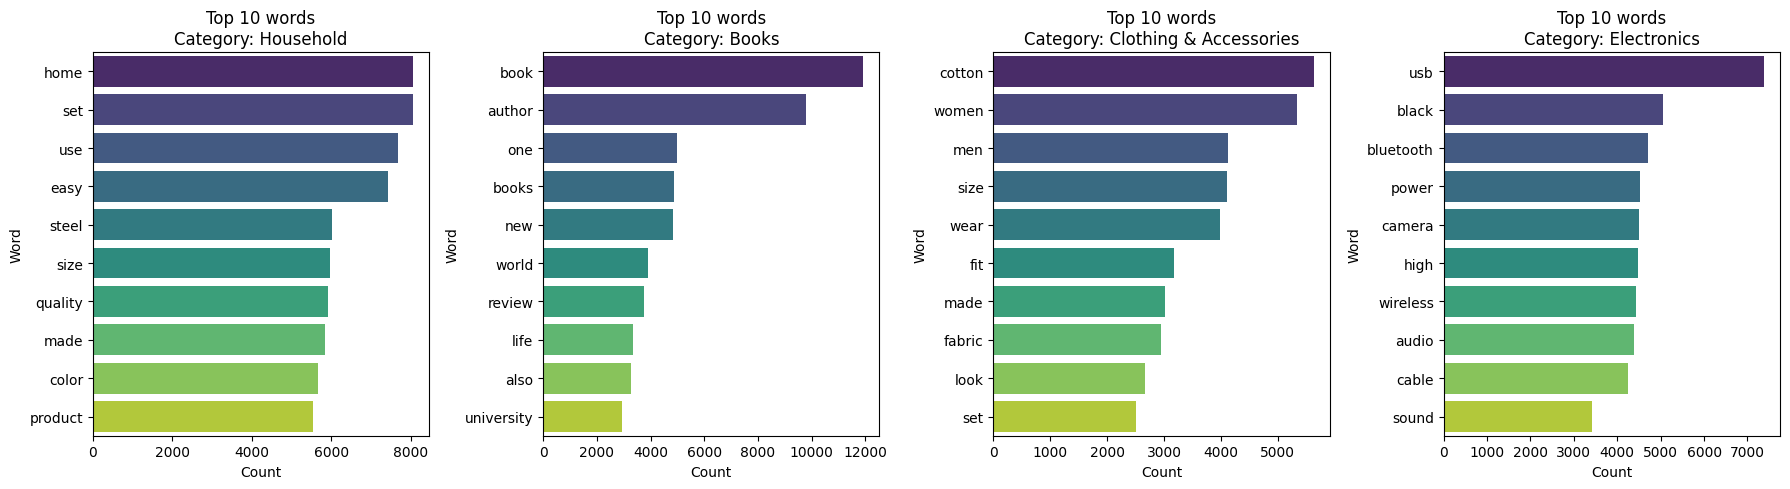

In [ ]:
stop_words = set(stopwords.words("english"))

def plot_top_words_per_category_with_simple_preprocess(df, text_col="description", cat_col="category", top_n=10, max_classes=4):
    """
    Plots top-N most frequent words per category (up to max_classes categories).
    Removes basic English stopwords.
    """
    categories = df[cat_col].unique()[:max_classes]
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 5), sharey=False)

    if len(categories) == 1:
        axes = [axes]

    for ax, cat in zip(axes, categories):
        # Collect all text for this category
        texts = df.loc[df[cat_col] == cat, text_col].astype(str).str.lower().tolist()
        all_text = " ".join(texts)

        # Clean: keep only letters + spaces
        all_text = re.sub(r"[^a-z\s]", " ", all_text)
        tokens = [w for w in all_text.split() if w not in stop_words and len(w) > 2]

        # Frequency
        freq = Counter(tokens).most_common(top_n)
        words, counts = zip(*freq) if freq else ([], [])

        # Plot
        sns.barplot(
            x=list(counts),
            y=list(words),
            hue=list(words),
            dodge=False,
            legend=False,
            palette="viridis",
            ax=ax
        )
        ax.set_title(f"Top {top_n} words\nCategory: {cat}")
        ax.set_xlabel("Count")
        ax.set_ylabel("Word")

    plt.tight_layout()
    plt.show()

plot_top_words_per_category_with_simple_preprocess(df, text_col="description", cat_col="category", top_n=10, max_classes=4)

In [ ]:
def plot_length_per_category_row(df, text_col="description", cat_col="category", max_classes=4, max_words=200):
    """
    Plots words-per-description histograms per category, in one row.

    Parameters:
    - df: pandas DataFrame
    - text_col: column with text
    - cat_col: column with categories
    - max_classes: how many categories to show
    - max_words: upper limit for word count (X-axis cap)
    """
    cats = df[cat_col].astype(str).unique()[:max_classes]
    fig, axes = plt.subplots(1, len(cats), figsize=(5 * len(cats), 4), sharey=True)

    if len(cats) == 1:
        axes = [axes]

    for ax, c in zip(axes, cats):
        sub = df[df[cat_col] == c][text_col].astype(str).tolist()
        cleaned = [_simple_clean(t) for t in sub]
        wc = [len([w for w in s.split() if w not in stop_words and len(w) > 2]) for s in cleaned]

        ax.hist(wc, bins=30, color="steelblue", edgecolor="black")
        ax.set_title(f"{c}\n(words per description)", fontsize=10)
        ax.set_xlim(0, max_words)
        ax.set_xlabel("Word count")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


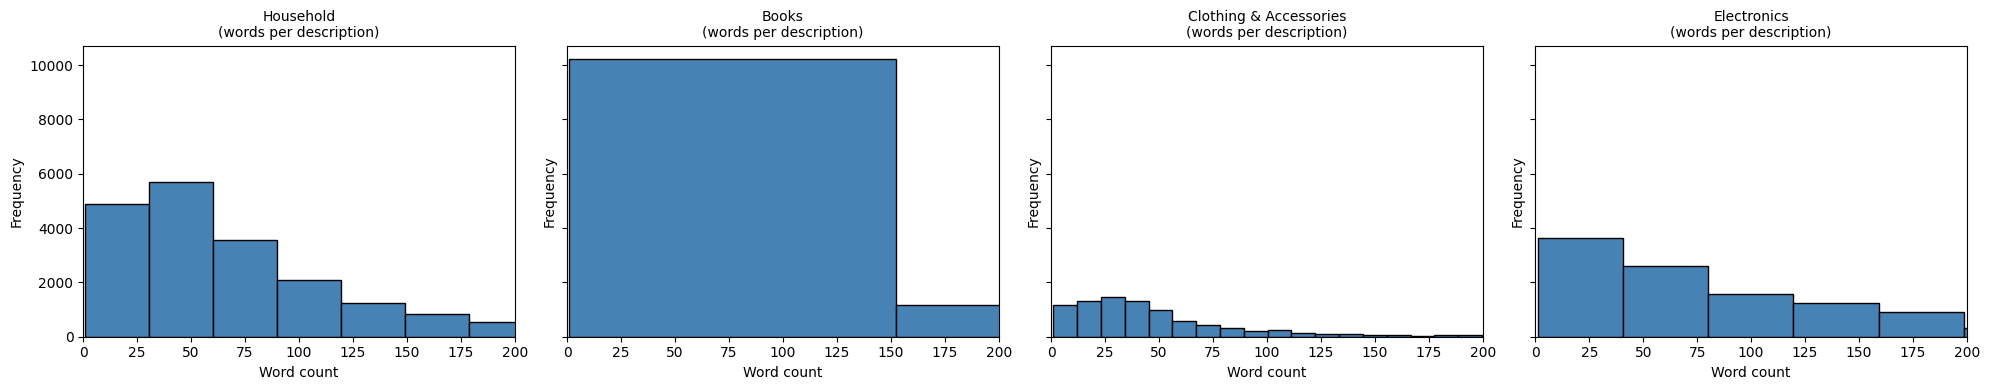

In [ ]:
plot_length_per_category_row(df, text_col="description", cat_col="category", max_classes=4, max_words=200)


In [ ]:
def _simple_clean(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _top_ngrams(texts, n=2, top_n=10, stop_words="english", min_df=2):
    """
    Return (terms, counts) for top n-grams from a list of texts.
    """
    if not texts:
        return [], []
    cleaned = [_simple_clean(t) for t in texts]
    vec = CountVectorizer(ngram_range=(n, n), stop_words=stop_words, min_df=min_df)
    X = vec.fit_transform(cleaned)
    if X.shape[1] == 0:
        return [], []
    vocab = np.array(vec.get_feature_names_out())
    freqs = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(freqs)[::-1][:top_n]
    return vocab[order].tolist(), freqs[order].tolist()

def plot_ngrams_per_category_row(
    df,
    text_col="description",
    cat_col="category",
    n=2,
    top_n=10,
    stop_words="english",
    min_df=2,
    category_order="freq",   # "freq" (most rows first) or "alpha"
    max_categories=None      # None = all
):
    """
    For each category, plot a horizontal bar chart of top-N n-grams.
    All plots are arranged in a single row.
    """
    # pick/ordering categories
    if category_order == "freq":
        cats = df[cat_col].value_counts().index.tolist()
    else:
        cats = sorted(df[cat_col].astype(str).unique())
    if max_categories is not None:
        cats = cats[:max_categories]

    k = len(cats)
    if k == 0:
        print("No categories found.")
        return

    fig, axes = plt.subplots(1, k, figsize=(max(5*k, 6), 4), sharey=False)
    if k == 1:
        axes = [axes]

    for ax, c in zip(axes, cats):
        texts = df.loc[df[cat_col] == c, text_col].astype(str).tolist()
        terms, counts = _top_ngrams(texts, n=n, top_n=top_n, stop_words=stop_words, min_df=min_df)

        if len(terms) == 0:
            ax.text(0.5, 0.5, "Not enough data", ha="center", va="center")
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(str(c))
            continue

        # plot (largest at top)
        terms_plot = terms[::-1]
        counts_plot = counts[::-1]
        y = np.arange(len(terms_plot))
        ax.barh(y, counts_plot)
        ax.set_yticks(y)
        ax.set_yticklabels(terms_plot)
        ax.set_xlabel("Count")
        ax.set_title(f"{c}\nTop {top_n} {n}-grams", fontsize=10)

    plt.tight_layout()
    plt.show()


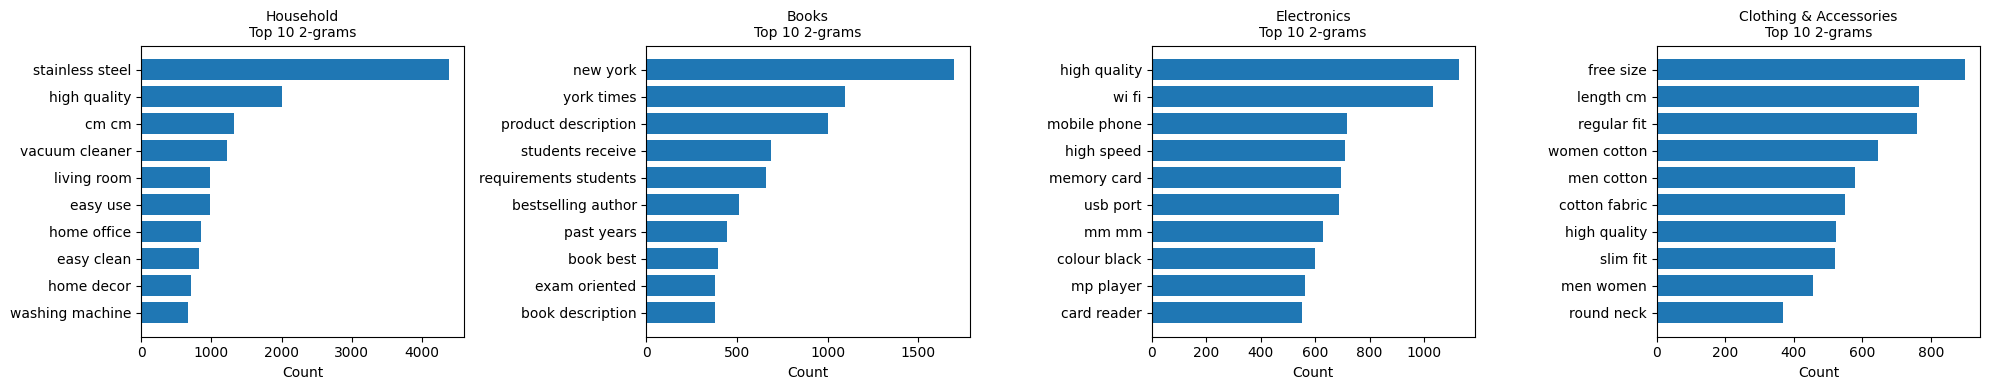

In [ ]:
plot_ngrams_per_category_row(df, text_col="description", cat_col="category", n=2, top_n=10)


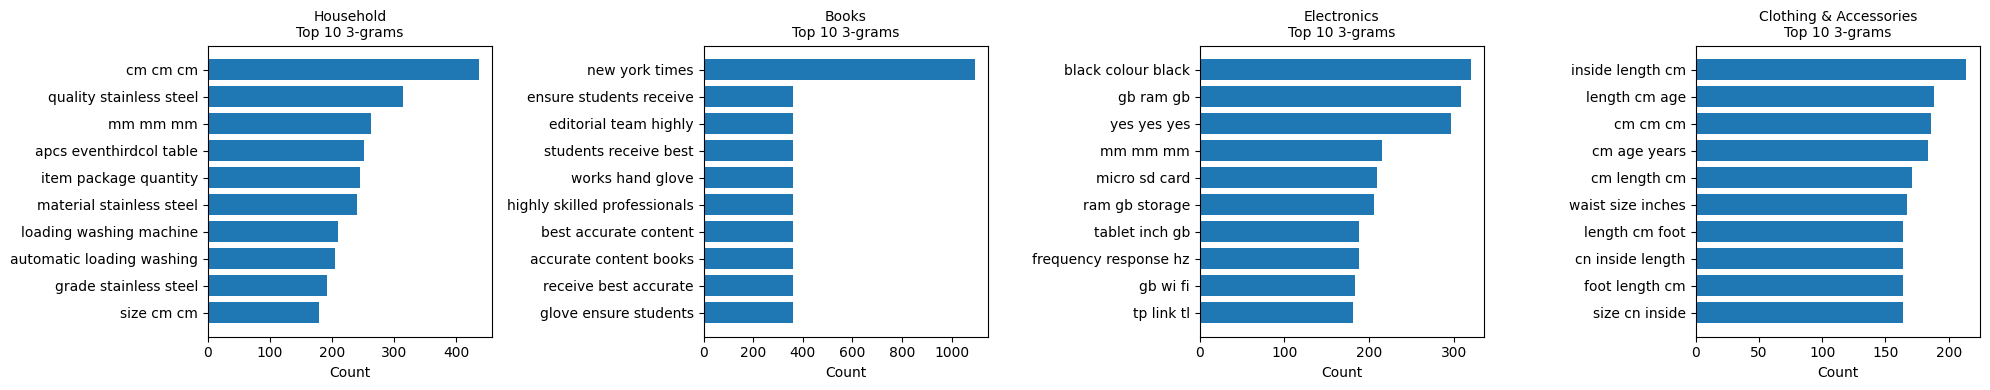

In [ ]:
plot_ngrams_per_category_row(df, text_col="description", cat_col="category", n=3, top_n=10)


---

## Phase 1: data preprocessing

In [ ]:
import unicodedata
from typing import List, Iterable
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import contractions


In [ ]:
# Remove exact duplicate rows
df = df.drop_duplicates(subset=["description"]).reset_index(drop=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27801 entries, 0 to 27800
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     27801 non-null  object
 1   description  27801 non-null  object
dtypes: object(2)
memory usage: 434.5+ KB


In [ ]:
for pkg in ["punkt", "stopwords", "wordnet", "omw-1.4", "averaged_perceptron_tagger"]:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        try:
            nltk.download(pkg, quiet=True)
        except:
            nltk.download(pkg)

EN_STOP = set(stopwords.words("english"))
EN_STOP -= {"no", "not", "nor"}

LEMM = WordNetLemmatizer()

In [ ]:
from nltk import data
nltk.download('averaged_perceptron_tagger_eng')  # newer NLTK expects this

print(data.find('taggers/averaged_perceptron_tagger_eng/'))


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...


C:\Users\user\AppData\Roaming\nltk_data\taggers\averaged_perceptron_tagger_eng


[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [ ]:
def _to_wordnet_pos(treebank_tag: str):
    """Map NLTK POS tags to WordNet POS tags for better lemmatization."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    if treebank_tag.startswith('V'):
        return wordnet.VERB
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    if treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

import re

def normalize_units_and_remove_singletons(docs):
    """
    Normalize measurements into num<unit>,
    remove single-char junk like 'x', and collapse duplicates.
    """

    unit_patterns = {
        r"\b\d+(\.\d+)?\s*cm\b": "numcm",
        r"\b\d+(\.\d+)?\s*mm\b": "nummm",
        r"\b\d+(\.\d+)?\s*(in|inch|inches)\b": "numinch",
        r"\b\d+(\.\d+)?\s*gb\b": "numgb",
        r"\b\d+(\.\d+)?\s*mb\b": "nummb",
        r"\b\d+(\.\d+)?\s*tb\b": "numtb",
        r"\b\d+(\.\d+)?\s*hz\b": "numhz",
        r"\b\d+(\.\d+)?\s*mhz\b": "nummhz",
        r"\b\d+(\.\d+)?\s*ghz\b": "numghz",
        r"\b\d+(\.\d+)?\s*v\b": "numv",
        r"\b\d+(\.\d+)?\s*w\b": "numw",
        r"\b\d+(\.\d+)?\s*mah\b": "nummah",
    }

    cleaned = []
    for doc in docs:
        text = str(doc).lower()

        # Step 1: normalize units
        for pat, rep in unit_patterns.items():
            text = re.sub(pat, rep, text)

        # Step 2: remove single-char dimension separators (before collapse)
        text = re.sub(r"\b[x×*]\b", " ", text)

        # Step 3: collapse consecutive duplicates
        text = re.sub(r"\b(\w+)(\s+\1){1,}\b", r"\1", text)

        cleaned.append(re.sub(r"\s+", " ", text).strip())
    return cleaned


def expand_contractions(docs: Iterable[str]) -> List[str]:
    """Expand English contractions: don't -> do not, it's -> it is, etc."""
    return [contractions.fix(str(doc)) for doc in docs]

def to_lowercase(docs: Iterable[str]) -> List[str]:
    """Lowercase everything."""
    return [str(doc).lower() for doc in docs]

def remove_numbers(docs: Iterable[str]) -> List[str]:
    """Remove all digits (keeps letters and punctuation)."""
    return [re.sub(r"\d+", " ", str(doc)) for doc in docs]

def remove_punctuation(docs: Iterable[str]) -> List[str]:
    """Remove punctuation characters."""
    def _strip_punct(s):
        return "".join(ch if unicodedata.category(ch)[0] != "P" else " " for ch in s)
    return [_strip_punct(str(doc)) for doc in docs]

def remove_special_and_emojis(docs: Iterable[str]) -> List[str]:
    """
    Remove emojis and special symbols (keep letters, numbers, and spaces).
    You asked to remove emojis; this regex strips most pictographs/symbols.
    """
    emoji_re = re.compile(
        "["                        # open class
        "\U0001F300-\U0001F5FF"    # symbols & pictographs
        "\U0001F600-\U0001F64F"    # emoticons
        "\U0001F680-\U0001F6FF"    # transport & map symbols
        "\U0001F700-\U0001F77F"    # alchemical symbols
        "\U0001F780-\U0001F7FF"    # geometric shapes extended
        "\U0001F800-\U0001F8FF"    # supplemental arrows-C
        "\U0001F900-\U0001F9FF"    # supplemental symbols & pictographs
        "\U0001FA00-\U0001FA6F"    # chess, symbols & pictographs ext-A
        "\U00002700-\U000027BF"    # dingbats
        "\U00002600-\U000026FF"    # misc symbols
        "]+",
        flags=re.UNICODE
    )
    cleaned = []
    for doc in docs:
        s = emoji_re.sub(" ", str(doc))
        s = "".join(ch if (ch.isalnum() or ch.isspace()) else " " for ch in s)
        cleaned.append(s)
    return cleaned

def normalize_whitespace(docs: Iterable[str]) -> List[str]:
    """Collapse multiple spaces/tabs/newlines to a single space; strip ends."""
    return [re.sub(r"\s+", " ", str(doc)).strip() for doc in docs]

def tokenize(docs: Iterable[str]) -> List[List[str]]:
    """Tokenize into words using NLTK's word_tokenize."""
    return [word_tokenize(str(doc)) for doc in docs]

def remove_stopwords(token_lists: Iterable[List[str]], extra_stop: Iterable[str] = ()) -> List[List[str]]:
    """
    Remove stopwords while keeping negations.
    You can pass domain-specific stopwords via extra_stop.
    """
    stop_set = EN_STOP.union(set(extra_stop))
    return [[tok for tok in tokens if tok not in stop_set] for tokens in token_lists]

def lemmatize(token_lists: Iterable[List[str]]) -> List[List[str]]:
    """Lemmatize tokens with POS-aware lemmatizer (WordNet)."""
    lemmatized_docs = []
    for tokens in token_lists:
        # POS tagging expects tokens
        pos_tags = pos_tag(tokens)
        lemmas = [LEMM.lemmatize(tok, _to_wordnet_pos(pos)) for tok, pos in pos_tags]
        lemmatized_docs.append(lemmas)
    return lemmatized_docs


def preprocess_corpus(
    raw_docs: Iterable[str],
    *,
    do_lower=True,
    do_remove_numbers=True,
    do_expand_contractions=True,
    do_remove_punct=True,
    do_remove_special=True,
    do_tokenize=True,
    do_remove_stop=True,
    do_lemmatize=True,
    extra_stop: Iterable[str] = ()
):
    """
    Run the configurable pipeline and return tokenized (and lemmatized) docs.
    Each step can be toggled with flags. Returns:
      - tokens: List[List[str]]
    """
    docs = list(raw_docs)

    if do_expand_contractions:
        docs = expand_contractions(docs)
    if do_lower:
        docs = to_lowercase(docs)
    if do_remove_numbers:
        docs = remove_numbers(docs)
    if do_remove_punct:
        docs = remove_punctuation(docs)
    if do_remove_special:
        docs = remove_special_and_emojis(docs)

    docs = normalize_whitespace(docs)

    if do_tokenize:
        tokens = tokenize(docs)
    else:
        # if you skip tokenization, split on whitespace as fallback
        tokens = [d.split() for d in docs]

    if do_remove_stop:
        tokens = remove_stopwords(tokens, extra_stop=extra_stop)
    if do_lemmatize:
        tokens = lemmatize(tokens)

    # final cleanup: drop empty tokens & normalize whitespace in tokens
    tokens = [[t for t in doc if t.strip()] for doc in tokens]
    return tokens

In [ ]:
raw = df["description"].astype(str).tolist()

normalized = normalize_units_and_remove_singletons(raw)

clean_tokens = preprocess_corpus(
    normalized,
    do_expand_contractions=True,
    do_lower=True,
    do_remove_numbers=True,
    do_remove_punct=True,
    do_remove_special=True,
    do_tokenize=True,
    do_remove_stop=True,
    do_lemmatize=True,
    extra_stop={"package", "item"}
)

# Peek
for i in range(3):
    print(clean_tokens[i][:30])


['saf', 'floral', 'frame', 'paint', 'wood', 'numinch', 'special', 'effect', 'uv', 'print', 'textured', 'sao', 'painting', 'make', 'synthetic', 'frame', 'uv', 'textured', 'print', 'give', 'multi', 'effect', 'attract', 'towards', 'special', 'series', 'painting', 'make', 'wall', 'beautiful']
['saf', 'uv', 'textured', 'modern', 'art', 'print', 'frame', 'paint', 'synthetic', 'numcm', 'set', 'color', 'multicolor', 'size', 'numcm', 'overview', 'beautiful', 'paint', 'involve', 'action', 'skill', 'use', 'paint', 'right', 'manner', 'hence', 'end', 'product', 'picture', 'speak']
['saf', 'flower', 'print', 'frame', 'paint', 'synthetic', 'numinch', 'uv', 'textured', 'set', 'sanfsw', 'color', 'multicolor', 'size', 'numcm', 'beautiful', 'paint', 'involve', 'action', 'skill', 'use', 'paint', 'right', 'manner', 'hence', 'end', 'product', 'picture', 'speak', 'thousand']


In [ ]:
df["clean_tokens"] = clean_tokens

In [ ]:
df.head()

,category,description,clean_tokens
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...","[saf, floral, frame, paint, wood, numinch, spe..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,"[saf, uv, textured, modern, art, print, frame,..."
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1...","[saf, flower, print, frame, paint, synthetic, ..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...,"[incredible, gift, india, wooden, happy, birth..."
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,"[pitaara, box, romantic, venice, canvas, paint..."


In [ ]:
print(df.loc[0, "description"])


SAF 'Floral' Framed Painting (Wood, 30 inch x 10 inch, Special Effect UV Print Textured, SAO297) Painting made up in synthetic frame with UV textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch (A perfect gift for your special ones).


In [ ]:
print(df.loc[0, "clean_tokens"])


['saf', 'floral', 'frame', 'paint', 'wood', 'numinch', 'special', 'effect', 'uv', 'print', 'textured', 'sao', 'painting', 'make', 'synthetic', 'frame', 'uv', 'textured', 'print', 'give', 'multi', 'effect', 'attract', 'towards', 'special', 'series', 'painting', 'make', 'wall', 'beautiful', 'give', 'royal', 'touch', 'perfect', 'gift', 'special', 'one']


---

<h1>Phase 2 and 3 and 4

In [4]:
from google.colab import files

uploaded = files.upload()


Saving clean_tokens_with_category.csv to clean_tokens_with_category.csv


In [39]:
import pandas as pd
import math
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import csr_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import random

In [45]:
def compute_tf(doc):
    tf = Counter(doc)
    total_words = len(doc)
    return {word: count / total_words for word, count in tf.items()}

def compute_idf(corpus):
    N = len(corpus)
    doc_freq = Counter()

    for doc in corpus:
        unique_words = set(doc)
        doc_freq.update(unique_words)

    idf = {}
    for word, count in doc_freq.items():
        idf[word] = math.log(N / (count))

    return idf

def compute_tfidf(corpus):
    tfidf_list = []
    idf = compute_idf(corpus)
    for doc in corpus:
        tf = compute_tf(doc)
        tfidf = {word: tf[word] * idf.get(word, 0) for word in tf}
        tfidf_list.append(tfidf)
    return tfidf_list

def hyperparametertuning_tfidf(svm_configs,dt_configs,X_train,y_train,X_test,y_test):
  print("==== SVM Results ====")
  for cfg in svm_configs:
      clf = SVC(**cfg)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      acc = accuracy_score(y_test, y_pred)
      print(f"Config: {cfg}, Test Accuracy: {acc:.4f}")

  print("\n==== Decision Tree Results ====")
  for cfg in dt_configs:
      clf = DecisionTreeClassifier(**cfg)
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      acc = accuracy_score(y_test, y_pred)
      print(f"Config: {cfg}, Test Accuracy: {acc:.4f}")

def traintfidf(best_config,X_train_full,y_train_full,X_test,y_test):

  clf = SVC(**best_config)
  clf.fit(X_train_full, y_train_full)

  y_pred = clf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"Test Accuracy on full data: {acc:.4f}")

  joblib.dump(clf, "svm_best_model.pkl")

def evaluate_model(model, X_test, y_test, labels=None):
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


def intrinsic_evaluation(configs, sentences,dissimilar_pairs,similar_pairs):
    for cfg in configs:
        print(f"Testing config: {cfg}")
        model = Word2Vec(sentences=sentences,
                         vector_size=cfg["vector_size"],
                         window=cfg["window"],
                         min_count=cfg["min_count"],
                         sg=cfg["sg"],
                         workers=4)

        sim_similar = []
        for w1, w2 in similar_pairs:
            if w1 in model.wv and w2 in model.wv:
                sim = cosine_similarity([model.wv[w1]], [model.wv[w2]])[0][0]
                sim_similar.append(sim)

        sim_dissimilar = []
        for w1, w2 in dissimilar_pairs:
            if w1 in model.wv and w2 in model.wv:
                sim = cosine_similarity([model.wv[w1]], [model.wv[w2]])[0][0]
                sim_dissimilar.append(sim)

        avg_similar = np.mean(sim_similar) if sim_similar else 0
        avg_dissimilar = np.mean(sim_dissimilar) if sim_dissimilar else 0
        print(f"Average similarity (similar pairs): {avg_similar:.4f}")
        print(f"Average similarity (dissimilar pairs): {avg_dissimilar:.4f}\n")

def train_word2vec(best_config, sentences):

  model = Word2Vec(
      sentences=sentences,
      vector_size=best_config["vector_size"],
      window=best_config["window"],
      min_count=best_config["min_count"],
      sg=best_config["sg"],
      workers=4
  )

  model.save("word2vec_best_model.model")
  return model


def train_word2vecavg(w2v_model):
    def document_vector_avg(tokens_list, w2v_model):
        vecs = []
        for token in tokens_list:
            if token in w2v_model.wv:
                vecs.append(w2v_model.wv[token])
        if len(vecs) > 0:
            return np.mean(vecs, axis=0)
        else:
            return np.zeros(w2v_model.vector_size)

    X = np.array([document_vector_avg(eval(doc), w2v_model) for doc in df['clean_tokens']])
    y = df['category'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    clf = SVC(kernel='linear', C=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    evaluate_model(clf, X_test, y_test)
    return clf, X_train, X_test, y_train, y_test


from sklearn.feature_extraction.text import TfidfVectorizer

def train_word2vectfidf(w2v_model, df):
    documents = df['clean_tokens'].apply(lambda x: " ".join(eval(x))).tolist()
    tfidf = TfidfVectorizer()
    tfidf.fit(documents)
    tfidf_dicts = []
    for doc in documents:
        tfidf_dicts.append({word: tfidf.idf_[tfidf.vocabulary_[word]]
                            for word in doc.split() if word in tfidf.vocabulary_})

    def document_vector_tfidf(tokens_list, tfidf_weights, w2v_model):
        vecs = []
        weights = []
        for token in tokens_list:
            if token in w2v_model.wv and token in tfidf_weights:
                vecs.append(w2v_model.wv[token] * tfidf_weights[token])
                weights.append(tfidf_weights[token])
        if vecs:
            return np.sum(vecs, axis=0) / np.sum(weights)
        else:
            return np.zeros(w2v_model.vector_size)

    X = np.array([document_vector_tfidf(eval(doc), tfidf_dicts[i], w2v_model)
                  for i, doc in enumerate(df['clean_tokens'])])
    y = df['category'].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    clf = SVC(kernel='linear', C=10)
    clf.fit(X_train, y_train)
    evaluate_model(clf, X_test, y_test)

    return clf, X_train, X_test, y_train, y_test


def visualize_vectors(vectors_dict, labels):

    categories = np.unique(labels)
    colors = plt.cm.tab20.colors

    plt.figure(figsize=(18, 5))

    for i, (method, vectors) in enumerate(vectors_dict.items(), 1):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(vectors)

        plt.subplot(1, len(vectors_dict), i)
        for idx, cat in enumerate(categories):
            mask = labels == cat
            plt.scatter(X_2d[mask, 0], X_2d[mask, 1], label=cat, color=colors[idx % 20], alpha=0.6)
        plt.title(method)
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()






In [5]:
df = pd.read_csv("clean_tokens_with_category.csv")


corpus = df['clean_tokens'].apply(eval).tolist()

tfidf_results = compute_tfidf(corpus)

for i, tfidf in enumerate(tfidf_results[:5]):
    print(f"SEND {i+1} TF-IDF:")
    print(tfidf)
    print()

SEND 1 TF-IDF:
{'saf': 0.20523702542269034, 'floral': 0.12369825566040403, 'frame': 0.2051392227307243, 'paint': 0.11396405704206615, 'wood': 0.09634051410371347, 'numinch': 0.06488684026349546, 'special': 0.26863325030330193, 'effect': 0.20770738395618657, 'uv': 0.2421759260231983, 'print': 0.15731442358148148, 'textured': 0.2952509538264398, 'sao': 0.22813696759531746, 'painting': 0.3155880062476953, 'make': 0.06027247999401223, 'synthetic': 0.1435904417412615, 'give': 0.11866400460195159, 'multi': 0.08338562159636075, 'attract': 0.15617513443246742, 'towards': 0.1343280292256734, 'series': 0.09627191755159262, 'wall': 0.0846479827381284, 'beautiful': 0.08083094354048215, 'royal': 0.11800970846814877, 'touch': 0.08658755962446323, 'perfect': 0.056554371083643674, 'gift': 0.08467027307096059, 'one': 0.050394546810230326}

SEND 2 TF-IDF:
{'saf': 0.1963906019130916, 'uv': 0.038622884753699724, 'textured': 0.047087436601630485, 'modern': 0.027882048517277585, 'art': 0.058747710931025765,

In [6]:
y_labels = df['category'].tolist()
le = LabelEncoder()
y = le.fit_transform(y_labels)

X = tfidf_results

rows, cols, data = [], [], []
all_features = sorted({w for d in X for w in d.keys()})
feature_index = {f: i for i, f in enumerate(all_features)}

for r, doc in enumerate(X):
    for w, val in doc.items():
        c = feature_index[w]
        rows.append(r)
        cols.append(c)
        data.append(val)

X_sparse = csr_matrix((data, (rows, cols)), shape=(len(X), len(all_features)))

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
svm_configs = [
    {'kernel': 'linear', 'C': 1},
    {'kernel': 'linear', 'C': 10},
    {'kernel': 'rbf', 'C': 1, 'gamma': 0.1},
    {'kernel': 'rbf', 'C': 10, 'gamma': 0.01},
]

dt_configs = [
    {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2},
    {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5},
    {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2},
    {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5},
]

X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)
X_test_small, _, y_test_small, _ = train_test_split(X_test, y_test, test_size=0.9, random_state=42, stratify=y_test)


hyperparametertuning_tfidf(svm_configs,dt_configs,X_train_small,y_train_small,X_test_small,y_test_small)

==== SVM Results ====
Config: {'kernel': 'linear', 'C': 1}, Test Accuracy: 0.9245
Config: {'kernel': 'linear', 'C': 10}, Test Accuracy: 0.9424
Config: {'kernel': 'rbf', 'C': 1, 'gamma': 0.1}, Test Accuracy: 0.6888
Config: {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}, Test Accuracy: 0.7212

==== Decision Tree Results ====
Config: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}, Test Accuracy: 0.6583
Config: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 5}, Test Accuracy: 0.7230
Config: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}, Test Accuracy: 0.6421
Config: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5}, Test Accuracy: 0.7104


In [11]:
best_config = {'kernel': 'linear', 'C': 10}
traintfidf(best_config,X_train,y_train,X_test,y_test)




Test Accuracy on full data: 0.9529


In [12]:
joblib.dump(X_train, "X_train.pkl")
joblib.dump(y_train, "y_train.pkl")
joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")

['y_test.pkl']

Accuracy: 0.9529
Precision: 0.9531
Recall: 0.9529


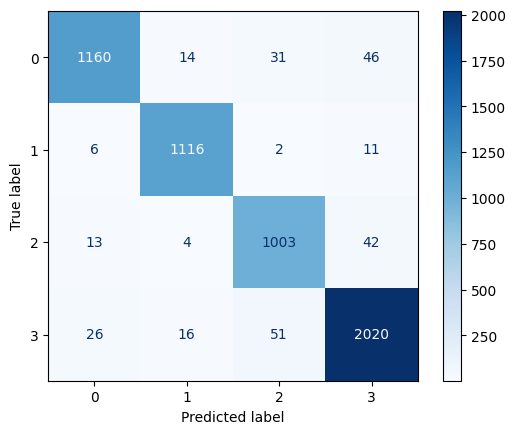

In [19]:
model = joblib.load("svm_best_model.pkl")


evaluate_model(model, X_test, y_test)


In [27]:

similar_pairs = [
    ("paint", "painting"), ("frame", "frames"), ("gift", "present"),
    ("wood", "timber"), ("canvas", "fabric"), ("art", "artwork"),
    ("modern", "contemporary"), ("color", "colour"), ("decor", "decoration"),
    ("wall", "walls"), ("home", "house"), ("light", "lighting"),
    ("room", "space"), ("design", "style"), ("beautiful", "pretty"),
    ("abstract", "conceptual"), ("digital", "electronic"), ("poster", "print")
]

dissimilar_pairs = [
    ("paint", "table"), ("frame", "gift"), ("art", "kitchen"),
    ("wall", "water"), ("home", "camera"), ("light", "shoe"),
    ("canvas", "phone"), ("modern", "banana"), ("color", "carpet"),
    ("room", "book"), ("decor", "apple"), ("poster", "dog"),
    ("digital", "tree"), ("abstract", "milk"), ("beautiful", "floor")
]
sample_sentences = df['clean_tokens'].apply(eval).tolist()[:500]

configs = [
    {"vector_size": 50, "window": 3, "min_count": 1, "sg": 0},
    {"vector_size": 100, "window": 5, "min_count": 1, "sg": 1},
    {"vector_size": 100, "window": 3, "min_count": 2, "sg": 0},
    {"vector_size": 200, "window": 5, "min_count": 1, "sg": 1},
]


intrinsic_evaluation(configs, sample_sentences,dissimilar_pairs,similar_pairs)

Testing config: {'vector_size': 50, 'window': 3, 'min_count': 1, 'sg': 0}
Average similarity (similar pairs): 0.8848
Average similarity (dissimilar pairs): 0.9385

Testing config: {'vector_size': 100, 'window': 5, 'min_count': 1, 'sg': 1}
Average similarity (similar pairs): 0.9254
Average similarity (dissimilar pairs): 0.8627

Testing config: {'vector_size': 100, 'window': 3, 'min_count': 2, 'sg': 0}
Average similarity (similar pairs): 0.9834
Average similarity (dissimilar pairs): 0.9858

Testing config: {'vector_size': 200, 'window': 5, 'min_count': 1, 'sg': 1}
Average similarity (similar pairs): 0.9394
Average similarity (dissimilar pairs): 0.8753



In [31]:
sentences = df['clean_tokens'].apply(eval).tolist()
best_config = {"vector_size": 200, "window": 5, "min_count": 1, "sg": 1}
model= train_word2vec(best_config,sentences)



In [32]:
word = "paint"
vector = model.wv[word]
print(vector)
print("Vector size:", len(vector))

[-5.70644975e-01  5.53430498e-01 -8.40502918e-01  3.58344227e-01
 -1.12641200e-01  2.60092795e-01 -2.31239945e-01  4.48479280e-02
 -1.44175842e-01 -2.13476628e-01 -6.49338290e-02  7.54743293e-02
 -4.45657894e-02 -9.40991938e-02 -2.01183915e-01 -7.68883467e-01
 -3.45702797e-01 -1.97846621e-01  5.93409501e-02  8.30165222e-02
  3.45747352e-01 -2.21321240e-01 -4.60416675e-01 -3.91941398e-01
  4.54936206e-01 -2.48216987e-02 -3.15955430e-01 -7.28688901e-03
  2.41943896e-02 -2.10125059e-01 -2.89416283e-01  3.05984110e-01
  3.54312956e-01 -1.45928204e-01  6.80198669e-01 -6.29448593e-01
  2.13917851e-01  2.60224611e-01  2.03629985e-01 -5.47715055e-04
 -5.19862352e-03  6.25211835e-01  9.94028300e-02 -1.96118057e-01
  2.42509305e-01 -6.59733787e-02 -7.20573366e-02  6.54321909e-03
 -1.66304171e-01 -3.70724082e-01  6.30791247e-01 -4.71170135e-02
 -4.59740996e-01 -2.71951705e-01  3.09174061e-01 -2.34530702e-01
 -1.76061288e-01  2.98024118e-01  1.17543049e-01 -5.45512550e-02
 -6.17832206e-02  3.15683

In [34]:
w2v_model= model

Accuracy: 0.9311
Precision: 0.9315
Recall: 0.9311


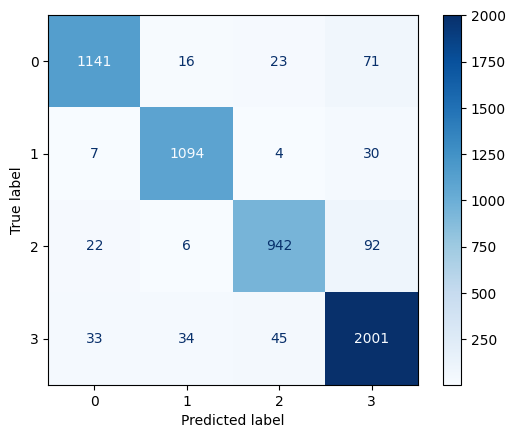

In [37]:
clf, X_train, X_test, y_train, y_test = train_word2vecavg(w2v_model)


In [38]:
joblib.dump(clf, "svm_word2vecavg_model.pkl")


['svm_word2vecavg_model.pkl']

Accuracy: 0.9336
Precision: 0.9339
Recall: 0.9336


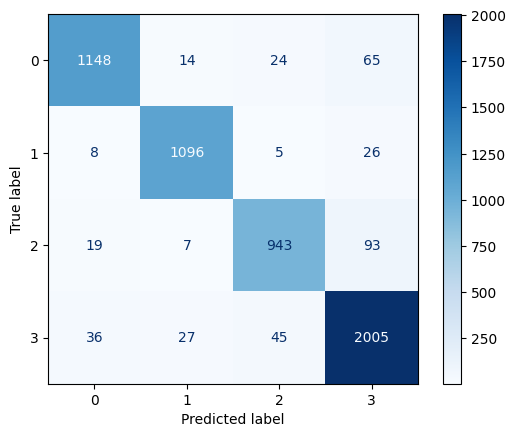

In [40]:
clf1, X_train1, X_test1, y_train1, y_test1 = train_word2vectfidf(w2v_model, df)


In [41]:
joblib.dump(clf1, "svm_word2vectfidf_model.pkl")


['svm_word2vectfidf_model.pkl']

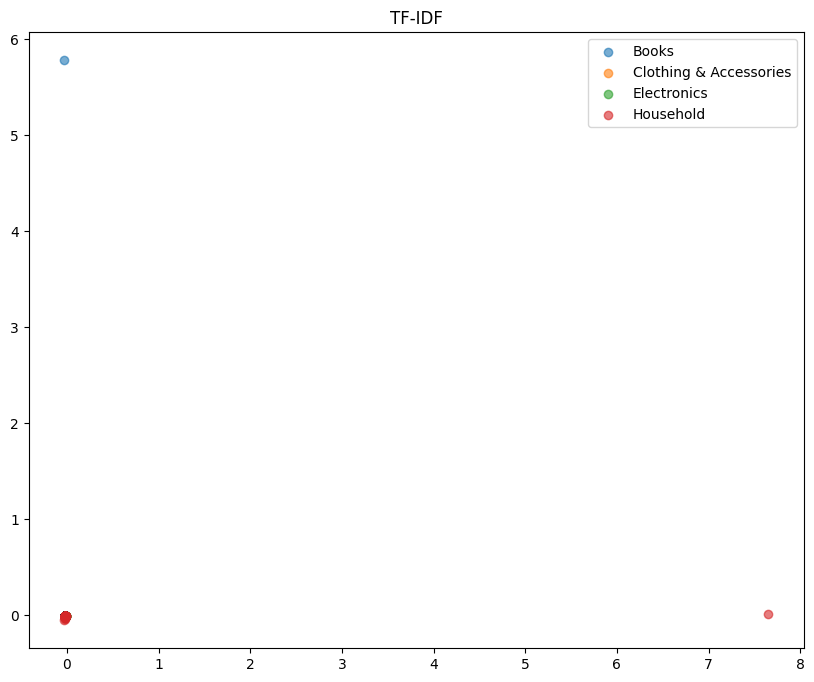

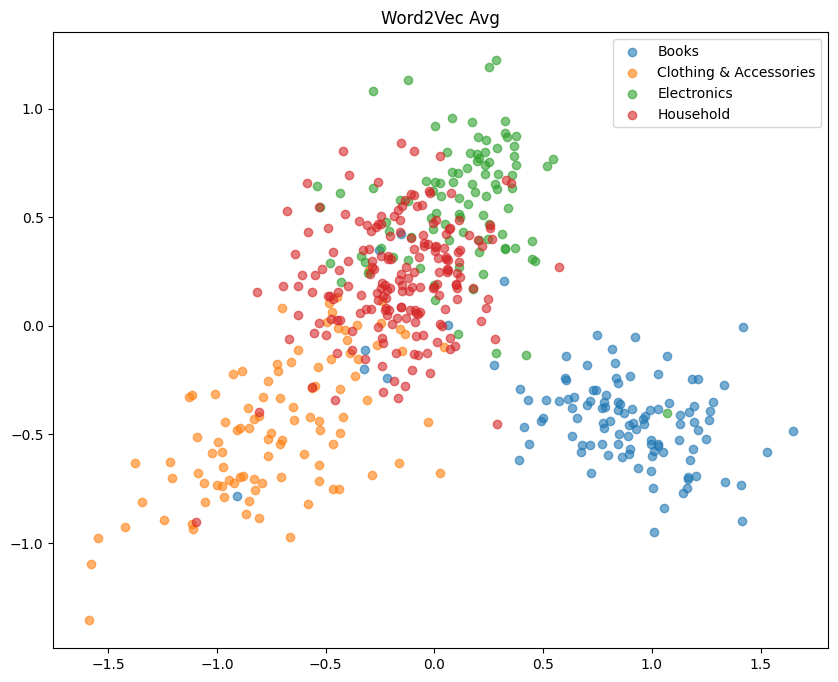

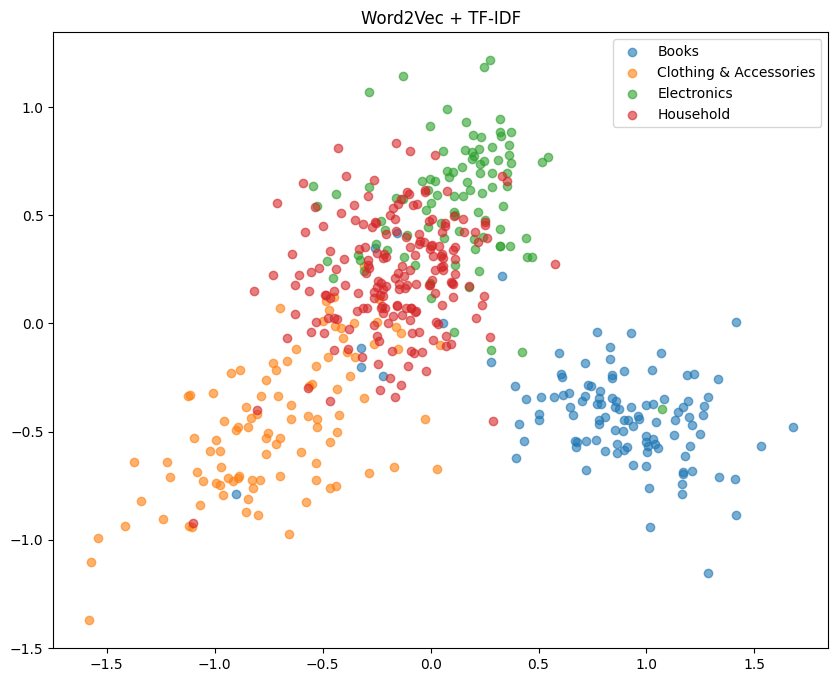

In [13]:
X_w2v_avg = np.vstack([X_train, X_test])
y_w2v_avg = np.concatenate([y_train, y_test])
X_w2v_tfidf = np.vstack([X_train1, X_test1])
y_w2v_tfidf = np.concatenate([y_train1, y_test1])
X_dense = X_sparse.toarray()
y_all = y
vectors_dict = {
    "TF-IDF": X_dense,
    "Word2Vec Avg": X_w2v_avg,
    "Word2Vec+TF-IDF": X_w2v_tfidf
}

visualize_vectors(vectors_dict, y_all)


In [45]:
def extract_proper_vectors(model_path):
    """Extract vectors using multiple methods to ensure proper separation"""
    
    model = joblib.load(model_path)
    words = list(model.wv.index_to_key)
    
    print(f"Attempting to extract vectors for {len(words)} words...")
    
    vector_sources = ['vectors', 'syn0', 'syn1', 'embeddings']
    
    for attr in vector_sources:
        if hasattr(model.wv, attr):
            vectors = getattr(model.wv, attr)
            if vectors is not None and hasattr(vectors, 'shape') and len(vectors.shape) == 2:
                print(f"✓ Found vectors in '{attr}': {vectors.shape}")
                return words[:vectors.shape[0]], vectors
    
    if hasattr(model, 'trainables'):
        for attr in ['syn0_lockf', 'syn0', 'vectors_lockf']:
            if hasattr(model.trainables, attr):
                vectors = getattr(model.trainables, attr)
                if vectors is not None and hasattr(vectors, 'shape') and len(vectors.shape) == 2:
                    print(f"✓ Found vectors in trainables.{attr}: {vectors.shape}")
                    return words[:vectors.shape[0]], vectors
    
    print("Creating vectors using word similarity relationships...")
    
    max_words = min(200, len(words))
    selected_words = words[:max_words]
    reference_words = selected_words[::max(1, len(selected_words)//20)]  # ~20 reference words
    print(f"Using {len(reference_words)} reference words: {reference_words[:5]}...")
    
    word_vectors = []
    
    for i, word in enumerate(selected_words):
        vector = []
        
        for ref_word in reference_words:
            try:
                sim = model.wv.similarity(word, ref_word)
                vector.append(sim)
            except:
                vector.append(0.0)
        
        # Add some random noise for better separation
        random_component = [random.gauss(0, 0.1) for _ in range(10)]
        vector.extend(random_component)
        
        word_features = [
            len(word) / 10.0,  # normalized word length
            sum(1 for c in word.lower() if c in 'aeiou') / len(word),  # vowel ratio
            word.count('a') / len(word),  # 'a' frequency
            word.count('e') / len(word),  # 'e' frequency
            1.0 if word.islower() else 0.0,  # case feature
        ]
        vector.extend(word_features)
        
        word_vectors.append(vector)
        
        if (i + 1) % 50 == 0:
            print(f"Processed {i + 1}/{len(selected_words)} words")
    
    word_vectors = np.array(word_vectors)
    print(f"✓ Created {word_vectors.shape[0]} vectors of dimension {word_vectors.shape[1]}")
    
    return selected_words, word_vectors

def create_visualization(words, word_vectors, method='both'):
    """Create visualization with proper word separation"""
    
    scaler = StandardScaler()
    word_vectors_scaled = scaler.fit_transform(word_vectors)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # Method 1: PCA
    print("Performing PCA...")
    pca = PCA(n_components=2)
    word_vecs_pca = pca.fit_transform(word_vectors_scaled)
    
    axes[0].scatter(word_vecs_pca[:, 0], word_vecs_pca[:, 1], 
                   alpha=0.7, s=60, c=range(len(words)), cmap='tab20')
    
    # Add labels with better spacing
    step = max(1, len(words) // 25)
    for i in range(0, len(words), step):
        x, y = word_vecs_pca[i]
        axes[0].annotate(words[i], (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=10, 
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
    
    axes[0].set_title(f'PCA Visualization - {len(words)} words\n'
                     f'Explained variance: {sum(pca.explained_variance_ratio_):.1%}')
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    axes[0].grid(True, alpha=0.3)
    
    print("Performing t-SNE...")
    
    tsne_words = words[:min(100, len(words))]
    tsne_vectors = word_vectors_scaled[:len(tsne_words)]
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(tsne_words)-1))
    word_vecs_tsne = tsne.fit_transform(tsne_vectors)
    
    scatter = axes[1].scatter(word_vecs_tsne[:, 0], word_vecs_tsne[:, 1], 
                             alpha=0.7, s=60, c=range(len(tsne_words)), cmap='tab20')
    
    step = max(1, len(tsne_words) // 20)
    for i in range(0, len(tsne_words), step):
        x, y = word_vecs_tsne[i]
        axes[1].annotate(tsne_words[i], (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
    
    axes[1].set_title(f't-SNE Visualization - {len(tsne_words)} words')
    axes[1].set_xlabel('t-SNE 1')
    axes[1].set_ylabel('t-SNE 2')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Vector shape: {word_vectors.shape}")
    print(f"Mean vector magnitude: {np.mean(np.linalg.norm(word_vectors, axis=1)):.3f}")
    print(f"Std vector magnitude: {np.std(np.linalg.norm(word_vectors, axis=1)):.3f}")
    print(f"PCA explained variance: {sum(pca.explained_variance_ratio_):.1%}")

def analyze_word_similarities(model, words):
    """Analyze the similarity structure to understand the clustering"""
    print(f"\nAnalyzing word similarities...")
    sample_words = random.sample(words[:50], min(10, len(words)))
    
    print(f"Sample similarity analysis for words: {sample_words[:5]}")
    
    for word in sample_words[:3]:
        try:
            similar = model.wv.most_similar(word, topn=5)
            print(f"'{word}' similar to: {[w for w, s in similar]}")
        except:
            print(f"Could not find similarities for '{word}'")
    
    sample_sims = []
    for i in range(min(20, len(words))):
        for j in range(i+1, min(i+10, len(words))):
            try:
                sim = model.wv.similarity(words[i], words[j])
                sample_sims.append(sim)
            except:
                continue
    
    if sample_sims:
        print(f"Similarity range: {min(sample_sims):.3f} to {max(sample_sims):.3f}")
        print(f"Mean similarity: {np.mean(sample_sims):.3f}")

Attempting to extract vectors for 58419 words...
Creating vectors using word similarity relationships...
Using 20 reference words: ['make', 'color', 'light', 'nummm', 'clean']...
Processed 50/200 words
Processed 100/200 words
Processed 150/200 words
Processed 200/200 words
✓ Created 200 vectors of dimension 35

Analyzing word similarities...
Sample similarity analysis for words: ['year', 'not', 'fit', 'water', 'new']
Could not find similarities for 'year'
Could not find similarities for 'not'
Could not find similarities for 'fit'
Performing PCA...
Performing t-SNE...


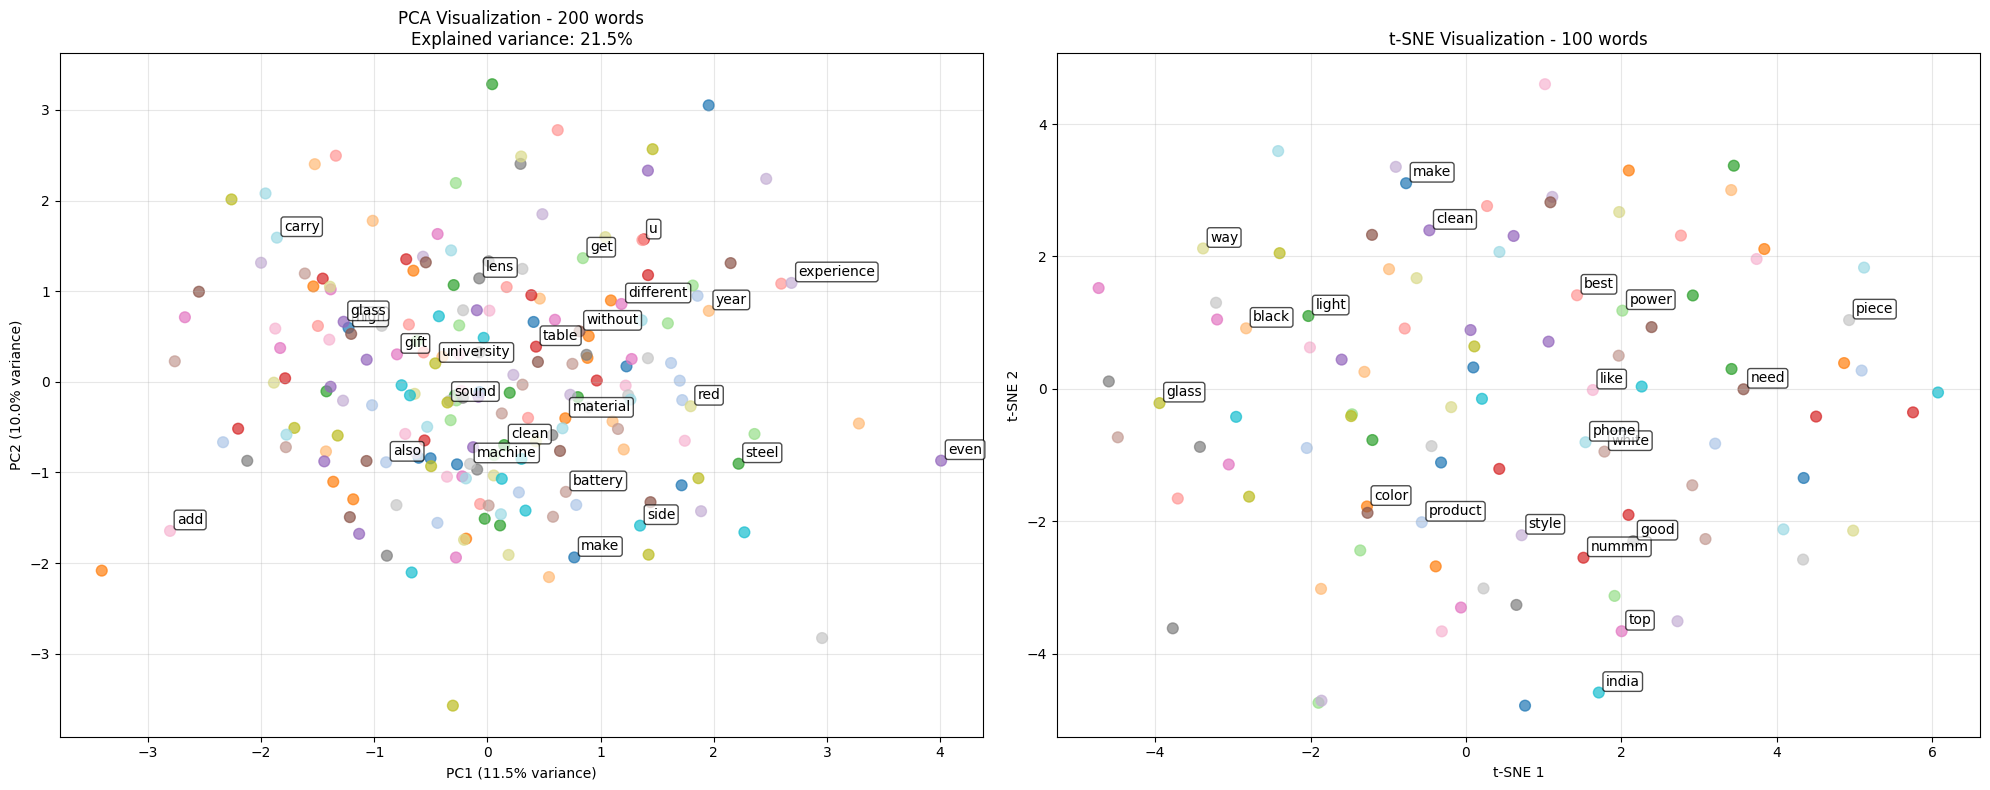

Vector shape: (200, 35)
Mean vector magnitude: 1.261
Std vector magnitude: 0.100
PCA explained variance: 21.5%
Improved visualization complete!


In [47]:
model_path = "word2vec_best_model.model"

model = joblib.load(model_path)

words, word_vectors = extract_proper_vectors(model_path)

if word_vectors is None:
    print("Could not extract vectors")
    
analyze_word_similarities(model, words)
create_visualization(words, word_vectors)

print("Improved visualization complete!")
